## 1.0 - Image Recognition Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# Load the training and test data
train_file_path = 'train.csv'
test_file_path = 'test.csv'
icml_face_data_file_path = 'icml_face_data.csv'


train_data = pd.read_csv(train_file_path)
test_data = pd.read_csv(test_file_path)
df = pd.read_csv(icml_face_data_file_path)

# Display the first few rows of the training data
print("Training Data:")
print(train_data.head())

# Display the first few rows of the test data
print("Test Data:")
print(test_data.head())

# Display the first few rows of the raw data
print("ICML face data:")
print(df.head())

Training Data:
   emotion                                             pixels
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1        0  151 150 147 155 148 133 111 140 170 174 182 15...
2        2  231 212 156 164 174 138 161 173 182 200 106 38...
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
Test Data:
                                              pixels
0  254 254 254 254 254 249 255 160 2 58 53 70 77 ...
1  156 184 198 202 204 207 210 212 213 214 215 21...
2  69 118 61 60 96 121 103 87 103 88 70 90 115 12...
3  205 203 236 157 83 158 120 116 94 86 155 180 2...
4  87 79 74 66 74 96 77 80 80 84 83 89 102 91 84 ...
ICML face data:
   emotion     Usage                                             pixels
0        0  Training  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1        0  Training  151 150 147 155 148 133 111 140 170 174 182 15...
2        2  Training  231 212 156 164 174 138 161 17

## EDA

In [3]:
# Get basic information about the dataset
df_info = df.info()

# Get descriptive statistics
df_describe = df.describe()

# Check for missing values
missing_values = df.isnull().sum()

# Check the distribution of the target variable (if applicable)
target_distribution = df['emotion'].value_counts()

# Display the outputs
df_info, df_describe, missing_values, target_distribution

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1    Usage   35887 non-null  object
 2    pixels  35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


(None,
             emotion
 count  35887.000000
 mean       3.323265
 std        1.873819
 min        0.000000
 25%        2.000000
 50%        3.000000
 75%        5.000000
 max        6.000000,
 emotion    0
  Usage     0
  pixels    0
 dtype: int64,
 emotion
 3    8989
 6    6198
 4    6077
 2    5121
 0    4953
 5    4002
 1     547
 Name: count, dtype: int64)

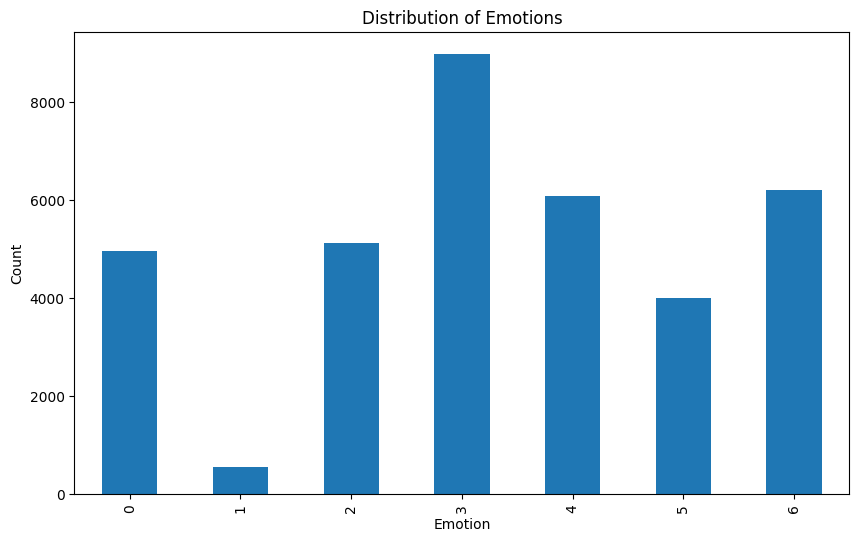

In [4]:
# Plot the distribution of emotions
plt.figure(figsize=(10, 6))
df['emotion'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Emotions')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.show()

In [5]:
# Preprocess 'pixels' column
df[' pixels'] = df[' pixels'].apply(lambda x: np.array(x.split(), dtype=float))

In [6]:
# Rename columns
new_column_names = {' pixels': 'pixels', ' Usage': 'usage'}
df = df.rename(columns=new_column_names)

In [7]:
# Check for missing values
df.isnull().sum()

emotion    0
usage      0
pixels     0
dtype: int64

In [8]:
# Compute summary statistics
pixel_data = np.stack(df['pixels'].values)  # Stack pixel values into a numpy array
print("Summary Statistics of Pixel Values:")
print("Mean:", np.mean(pixel_data))
print("Median:", np.median(pixel_data))
print("Minimum:", np.min(pixel_data))
print("Maximum:", np.max(pixel_data))
print("Standard Deviation:", np.std(pixel_data))

Summary Statistics of Pixel Values:
Mean: 129.38585663274074
Median: 134.0
Minimum: 0.0
Maximum: 255.0
Standard Deviation: 65.05789230083087


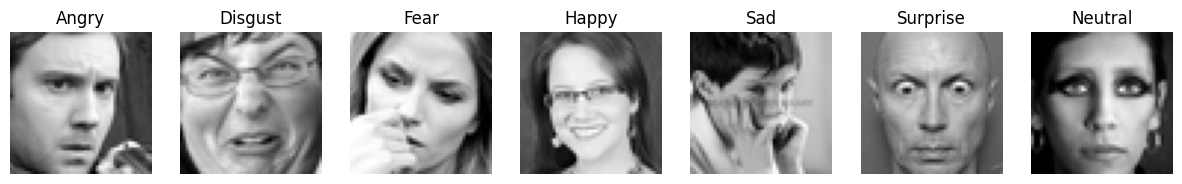

In [9]:
#Define emotions
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

# Plot one image from each class
fig, axes = plt.subplots(1, len(emotions), figsize=(15, 3))

for emotion_id, ax in zip(emotions.keys(), axes):
    # Find the first occurrence of each emotion in the DataFrame
    image_index = df[df['emotion'] == emotion_id].index[0]

    # Extract pixel values and reshape into 48x48 image
    image = df.loc[image_index, 'pixels'].reshape(48, 48)

    # Plot the image
    ax.imshow(image, cmap='gray')
    ax.set_title(emotions[emotion_id])
    ax.axis('off')

plt.show()

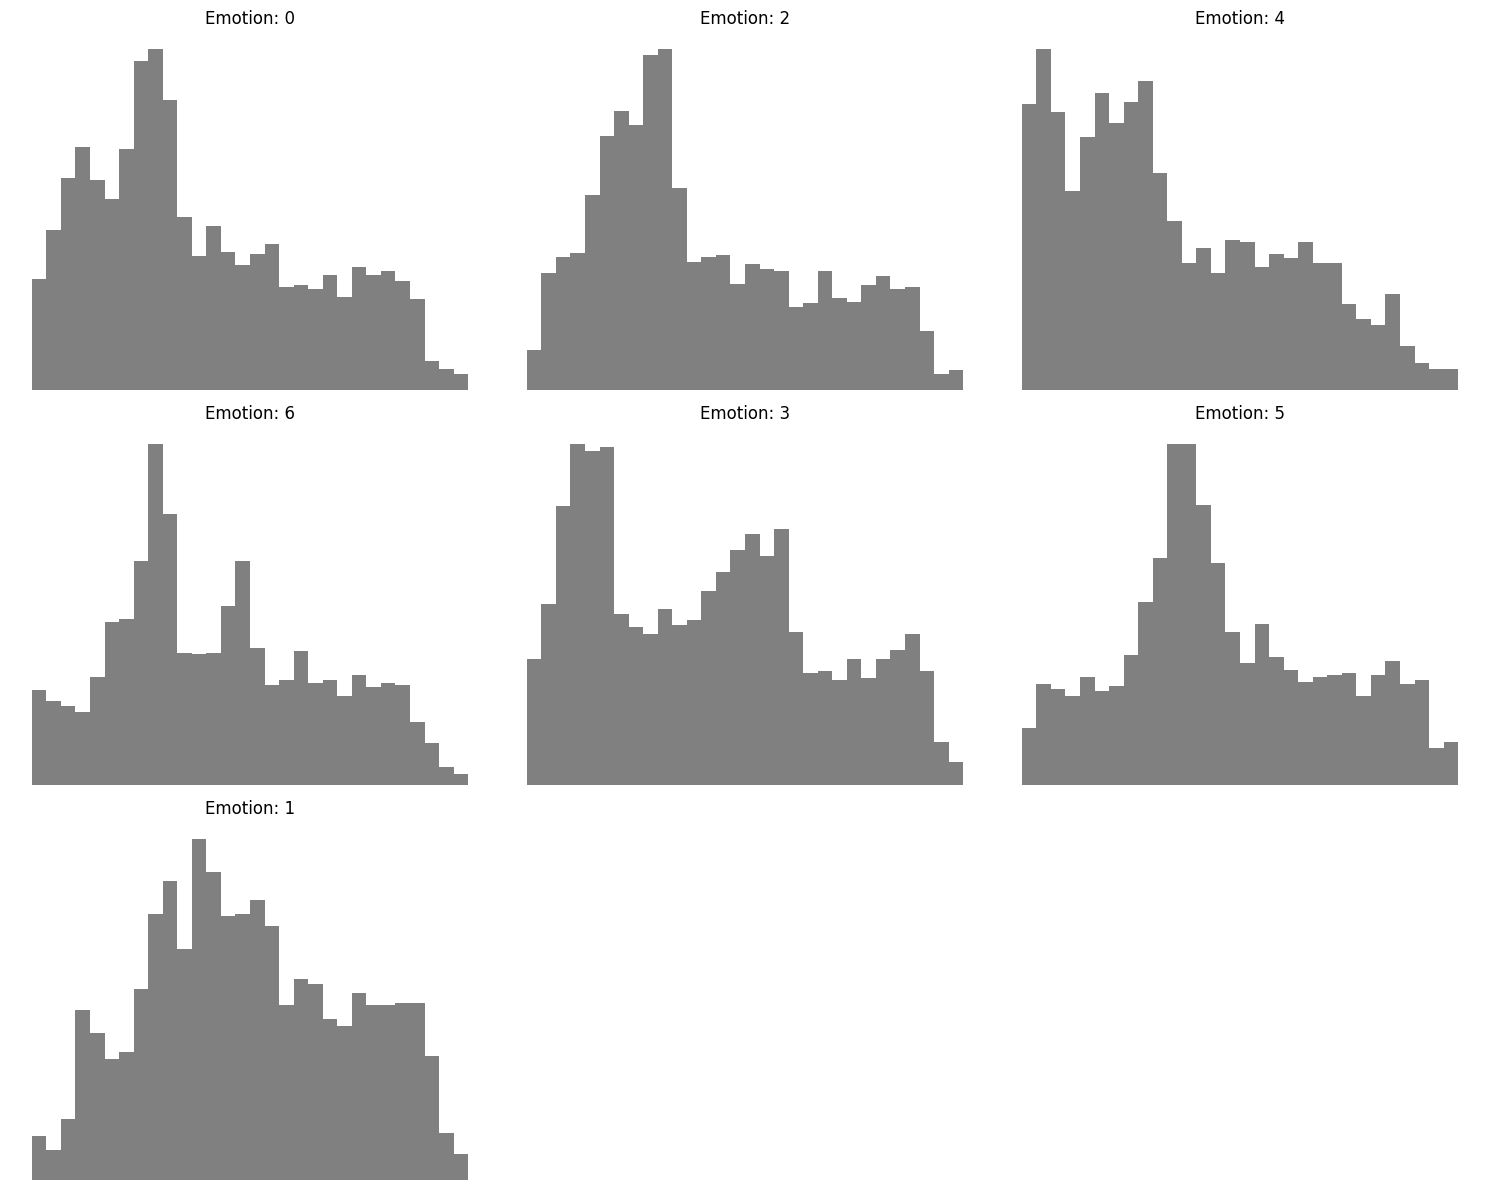

In [10]:
# Display histogram for each emotion type
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
emotions = train_data['emotion'].unique()
for i, ax in enumerate(axes.flat):
    if i < len(emotions):
        emotion_data = train_data[train_data['emotion'] == emotions[i]]
        pixel_data = np.array(list(emotion_data['pixels'].apply(lambda x: np.array(x.split(), dtype=int))))
        mean_pixels = np.mean(pixel_data, axis=0)
        ax.hist(mean_pixels, bins=30, color='gray')
        ax.set_title(f'Emotion: {emotions[i]}')
    ax.set_xlabel('Pixel Intensity')
    ax.set_ylabel('Frequency')
    ax.axis('off')
plt.tight_layout()
plt.show()

## Analysis

In [11]:
# Display the first few rows to understand the structure
print(df.columns)

Index(['emotion', 'usage', 'pixels'], dtype='object')


In [12]:
print("Train data columns:", train_data.columns)
print("Test data columns:", test_data.columns)

Train data columns: Index(['emotion', 'pixels'], dtype='object')
Test data columns: Index(['pixels'], dtype='object')


In [17]:
# Extract features and labels from the train data
X_train = np.array([np.fromstring(pixels, dtype=int, sep=' ') for pixels in train_data['pixels']])
y_train = tf.keras.utils.to_categorical(train_data['emotion'], num_classes=7)

# Extract features from the test data (no labels)
X_test = np.array([np.fromstring(pixels, dtype=int, sep=' ') for pixels in test_data['pixels']])

# Reshape to 48x48 images with 1 channel (grayscale)
X_train = X_train.reshape(-1, 48, 48, 1)
X_test = X_test.reshape(-1, 48, 48, 1)

# Normalize pixel values to [0, 1]
X_train = X_train / 255.0
X_test = X_test / 255.0

# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Define data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# Fit the data generator to the training data
datagen.fit(X_train)

In [18]:
# Display shapes to verify
print(f'X_train shape: {X_train.shape}')
print(f'X_val shape: {X_val.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_val shape: {y_val.shape}')


X_train shape: (22967, 48, 48, 1)
X_val shape: (5742, 48, 48, 1)
y_train shape: (22967, 7)
y_val shape: (5742, 7)


In [19]:
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# Fit the data generator to the training data
datagen.fit(X_train)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 46, 46, 32)        320       
                                                                 
 batch_normalization_4 (Bat  (None, 46, 46, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 23, 23, 32)        0         
 g2D)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 23, 23, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 batch_normalization_5 (Bat  (None, 21, 21, 64)       

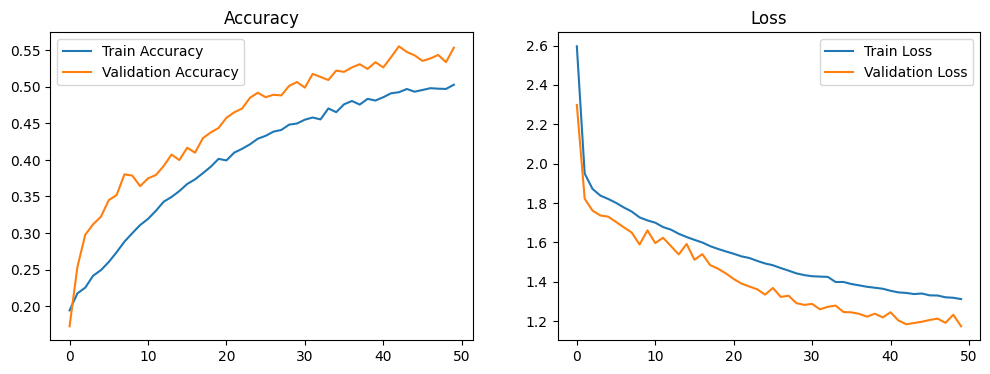

In [20]:
# Build the CNN model with Batch Normalization
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')
])

# Compile the model
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with data augmentation
history = model.fit(datagen.flow(X_train, y_train, batch_size=64),
                    epochs=50,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping])

# Evaluate the model on the validation set
val_loss, val_acc = model.evaluate(X_val, y_val)
print(f'Validation accuracy: {val_acc:.4f}')

# Plot training and validation accuracy and loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()

Epoch 1/100
359/359 [==============================] - 19s 43ms/step - loss: 2.1809 - accuracy: 0.2255 - val_loss: 1.9501 - val_accuracy: 0.2804
Epoch 2/100
359/359 [==============================] - 13s 37ms/step - loss: 1.7599 - accuracy: 0.3108 - val_loss: 1.6062 - val_accuracy: 0.3753
Epoch 3/100
359/359 [==============================] - 15s 42ms/step - loss: 1.6140 - accuracy: 0.3688 - val_loss: 1.5000 - val_accuracy: 0.4141
Epoch 4/100
359/359 [==============================] - 14s 38ms/step - loss: 1.5339 - accuracy: 0.4066 - val_loss: 1.5930 - val_accuracy: 0.4002
Epoch 5/100
359/359 [==============================] - 15s 42ms/step - loss: 1.4765 - accuracy: 0.4331 - val_loss: 1.3787 - val_accuracy: 0.4718
Epoch 6/100
359/359 [==============================] - 15s 41ms/step - loss: 1.4253 - accuracy: 0.4504 - val_loss: 1.5457 - val_accuracy: 0.4147
Epoch 7/100
359/359 [==============================] - 13s 37ms/step - loss: 1.4042 - accuracy: 0.4580 - val_loss: 1.2758 - val_ac

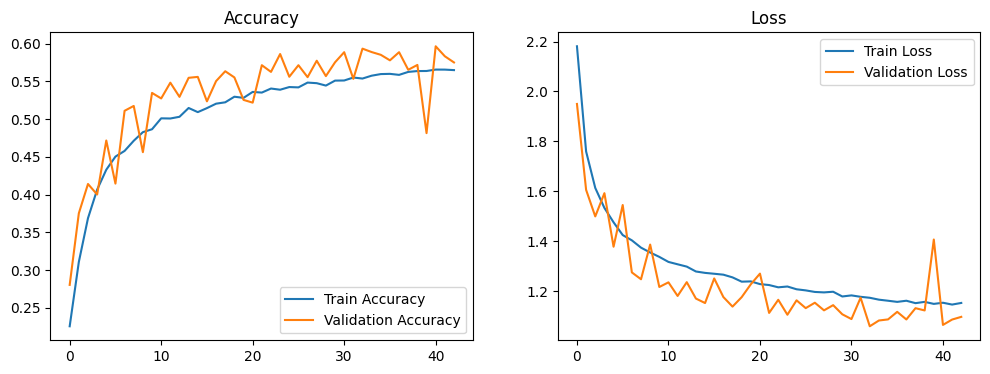

In [21]:
# Build the CNN model with Batch Normalization
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(7, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with data augmentation
history = model.fit(datagen.flow(X_train, y_train, batch_size=64),
                    epochs=100,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping])

# Evaluate the model on the validation set
val_loss, val_acc = model.evaluate(X_val, y_val)
print(f'Validation accuracy: {val_acc:.4f}')

# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()